# Computer Vision

In [29]:
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
from torch import nn
import numpy as np
from timeit import default_timer
from tqdm.auto import tqdm

## get dataset

In [ ]:
#using FashionMNIST
train_data = datasets.FashionMNIST(
    root="datasets",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="datasets",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [ ]:
len(train_data), len(test_data)

In [ ]:
class_names = train_data.classes
class_names

In [ ]:
class_to_idx = train_data.class_to_idx
class_to_idx

In [ ]:
image, label = test_data[0]
image, label

In [ ]:
image.shape

## visualize data

(-0.5, 27.5, 27.5, -0.5)

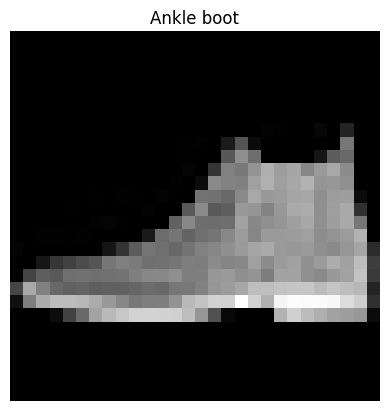

In [14]:
plt.imshow(image.squeeze(),cmap="gray")
plt.title(class_names[label])
plt.axis(False)

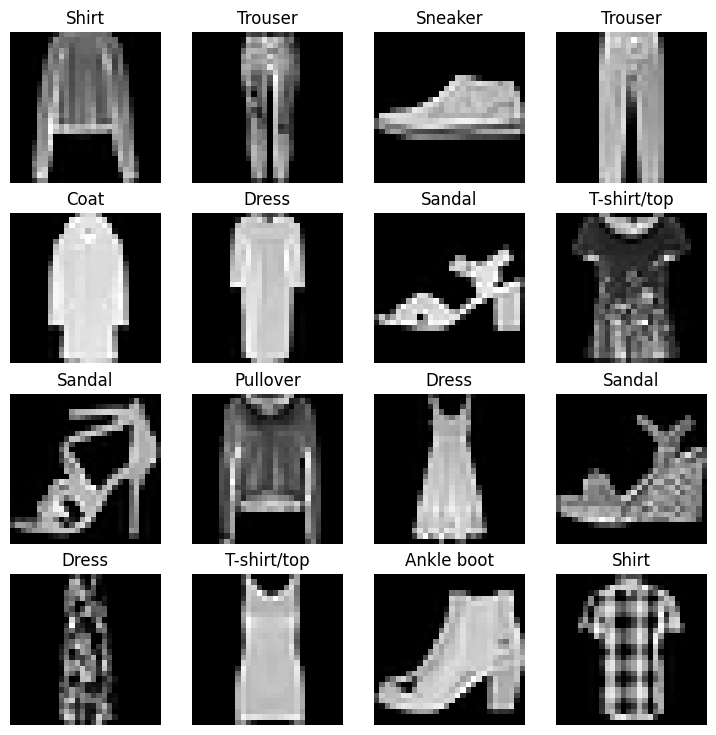

In [18]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

## prepare dataloader

In [20]:
#setup batch size hyperparameter
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [21]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f38ce9dbf10>,
 <torch.utils.data.dataloader.DataLoader at 0x7f38ce47efd0>)

In [22]:
len(train_dataloader), len(test_dataloader)

(1875, 313)

## create model

In [24]:
class FashionMNISTModelv0(nn.Module):

    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

model_8 = FashionMNISTModelv0(
    input_shape=784,
    hidden_units=10,
    output_shape=len(class_names)
)

In [25]:
dummy_x = torch.rand([1, 1, 28, 28])
model_8(dummy_x)

tensor([[ 0.1185, -0.1150,  0.2032, -0.1672,  0.1102,  0.0550,  0.1110, -0.2197,
          0.0122,  0.2629]], grad_fn=<AddmmBackward0>)

In [28]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model_8.parameters(), lr=0.1)

In [27]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [30]:
def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"train time on {device} = {total_time:.3f} seconds")
    return total_time

## train and test